In [15]:
import os

import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import rasterio as rio

The purpose of thiss notebook is to use regressor functions in thesis software and output LOGR output in addition to regression info!

In [2]:
def linreg():
    

    from sklearn.linear_model import LinearRegression
    

    N = file_np.npfile.shape[2]   # num partitions
    keyword = 'partition_'
    #os.mkdir('linreg') # FIXME! if this folder already exists it will still make a new one. make sure you do if else to check instead!
    #os.chdir('/Users/josemarmolejo/Thesis/processing/linreg')
    
    
    
    folder_name = work_space_dir + '/Linear_regression'
    if os.path.isdir(work_space_dir + folder_name):
      pass
    else:
      os.mkdir(folder_name)
    
    write_dir = folder_name +'/'
    
    
    # Does the heavy logistic regression lifting 
    def linreg_fn(N):
      
      linreg = LinearRegression().fit(file_np.X_train[:,:,0], file_np.y_train[:,0])
      score = linreg.score(file_np.X_test[:,:,N],file_np.y_test[:,N]) * 100
      predicted_label = linreg.predict(file_np.X_test[:,:,N])
      #decision_func = logr.decision_function(file_np.X_test[:,:,N])
      #log_prob = logr.predict_log_proba(file_np.X_test[:,:,N])
  
      # getting data / results per iteration each one can be accesed as function['score'], function['predicted_label'] etc.
      results = {
                       'score': score,
                       'predicted_label': predicted_label,
                       #'decision_func': decision_func,
                       #'log_prob': log_prob
                       }
      
      
      
      return results 
    
    
    
    # This function interprets svc prediction and parameters and exportrs to csv file for later use.
    def csv_data():
      
      for n in range(0,N): # FIXME: make N not 1!!!
        key = keyword + str(n + 1)
        arr = np.zeros([734,3])   # empty array framework
        
        # location
        arr[:,0] = file_np.test_loc[:,n].flatten()
        # prediction
        arr[:,1] = linreg_fn(n)['predicted_label'].flatten()
        # label
        arr[:,2] = file_np.y_test[:,n].flatten()
        
        export = arr
        # print(key)
        # print(export)
        # print()
        # print()
        # print()
        
        export_df = pd.DataFrame(export, columns=['location','prediction','label'])
        export_df.to_csv(write_dir + key+'.csv')  # WRITE CSV !!!!
       
      
  
     # This is the score part of dictionary
    def score_linreg():
      
      score_dict = {keyword+str(n+1): linreg_fn(n)['score'] for n in range(0,N)}
      columns = ['score']
      export_score = pd.DataFrame.from_dict(score_dict,orient='index',columns=columns)  # just making that dictionary to pd
      export_score.to_csv(write_dir + "linreg.csv")   # exporting to processing directory
      
      return export_score
    
  
    
    ### executing the functions ###
    csv_data()
    score_linreg()

# Testing output prior to running all partitions

In [3]:
workspace_dir = '/home/jmm688/github/abm_detect/data/workspace_reggressor2classifier'

In [4]:
### Loading in the satelite image

#variabels
xdim = 400    # cropped out E - W direction 
ydim = 400    # cropped out N - S direction
wv3dim = 16   # band or spectral resolution 

band = {
          1 : 'Coastal', 
          2 : 'Blue',
          3 : 'Green',
          4 : 'Yellow',
          5 : 'Red',
          6 : 'RedEdge',
          7 : 'NIR1',
          8 : 'NIR2',
          9 : 'SWIR-1',
          10: 'SWIR-2',
          11: 'SWIR-3',
          12: 'SWIR-4',
          13: 'SWIR-5',
          14: 'SWIR-6',
          15: 'SWIR-7',
          16: 'SWIR-8'

          }

# train test split
train = 0.2
test =  0.8
  
# loading in image
wv3_path = workspace_dir + '/fixed_field_area.tif'
#creates a rasterio object 
raster = rio.open(wv3_path, mode='r')

# the raw numpy array without processing
array = raster.read()[:,0:xdim,0:ydim]

In [5]:
### Loading in the mine locations or the LABELS

mineloc_path = workspace_dir + '/mine_locations_raster_1x1m.tif'

labels = rio.open(mineloc_path, mode='r')

labels_array = labels.read()[:,0:xdim,0:ydim]


In [6]:
array.shape

(16, 400, 400)

In [7]:
def flat_arr(arr):
    
    array = arr
    
    # if it is multispectral image
    if array.shape[0] == wv3dim:
  
    # creates a numpy array that will be correctly processed
        flat = array
      
      # this is the flattened array 
        flat = np.moveaxis(flat, 0, -1)
        flat = flat.reshape(160000,16)
      
    # if it is the target or variate (answers)  
    else:
      
        flat = array
              
      # this is the flattened array 
        flat = np.moveaxis(flat, 0, -1)
        flat = flat.reshape(160000,1)
    
    return flat






flat_label = flat_arr(labels_array)


In [8]:
# for raster predictions
flat = np.moveaxis(array, 0, -1)
flat = flat.reshape(160000,16)

In [9]:
### getting test and train data

# loading in training data + labels
trainX = pd.read_csv(workspace_dir + '/Train_X.csv',index_col = 0, header = 0)
train_y = pd.read_csv(workspace_dir + '/Train_y.csv',index_col = 0, header = 0)



# loading in test data
testX = pd.read_csv(workspace_dir + '/TestX.csv',index_col = 0, header = 0)
test_y = pd.read_csv(workspace_dir + '/Test_y.csv',index_col = 0, header = 0)



In [152]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(trainX, train_y)
score = linreg.score(testX, test_y) * 100
predict_raster_linreg = linreg.predict(flat)

In [153]:
score

48.79524404241241

Text(0.5, 1.0, 'Linear Regression\nVariate Predictions')

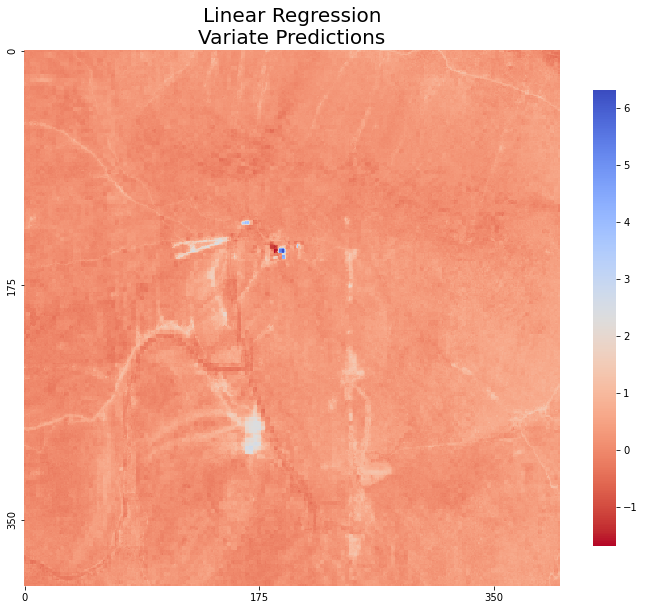

In [154]:
plt.figure(figsize = (12,12))
sns.heatmap(predict_raster_linreg.reshape([400,400]),cmap='coolwarm_r',xticklabels=175,yticklabels=175,cbar_kws={"shrink": 0.7},square=True)
plt.title('Linear Regression\nVariate Predictions',fontsize=20)


##### SAVE FIGURE #####
#plt.savefig('linreg_predict_TM',dpi=500)

In [272]:
# geting linreg parameters
coef = linreg.coef_[0,:]
b_int = linreg.intercept_

In [273]:
coef.shape

(16,)

In [158]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression

# making predictions on testing data and comparing it to true class labels in order to get MSE
pred_y = linreg.predict(testX)
true_y = test_y

# getting MSE
mse = mean_squared_error(true_y, pred_y)

In [274]:
pred_y.shape


(734, 1)

In [275]:
true_y.shape

(734, 1)

In [160]:
# making LOGR classifier based on linreg variate output

pred_trainX = linreg.predict(trainX)
pred_testX = linreg.predict(testX)

# reshaping to fit train and test dimension
p_train = np.reshape(pred_trainX,[2931,1])
p_test = np.reshape(pred_testX, [734,1])


# new model generated from linreg variates + LOGR
log_linreg = LogisticRegression(C=.001, max_iter=10).fit(p_train, train_y)

# linreg based LOGR score
score_logr = log_linreg.score(p_test, test_y) * 100

/home/jmm688/conda/miniconda3/envs/AI/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


# Dataframe development and visualization

In [258]:
# creating a list comp with the name coef + i in number of coeficients
coef_col = [str('coef '+str(i)) for i in range(0,coef.shape[0])]
df= pd.DataFrame(coef).T
df.columns = coef_col

In [266]:
df

,coef 0,coef 1,coef 2,coef 3,coef 4,coef 5,coef 6,coef 7,coef 8,coef 9,coef 10,coef 11,coef 12,coef 13,coef 14,coef 15
0,0.000982,0.000005,0.000124,-0.000752,0.000108,0.000413,-0.000064,-0.000153,-0.000572,0.000063,0.001368,0.000647,-0.001173,-0.000167,-0.000003,0.00001


In [166]:
# generating a results dictionary similar to thesis software output
results = {
               'score': score,
               'score_LOGR' : score_logr,
               'predicted_label': pred_y,
               'MSE' : mse,
               'b_int' : b_int,
               'coef_arr' : coef,
               'coef_col' : coef_col
               #'decision_func': decision_func,
               #'log_prob': log_prob
    
               }

In [260]:
# generates coef dataframe (easiest to do this way and then add individual columns)
for_df = pd.DataFrame(results['coef_arr']).T
for_df.columns = coef_col

In [261]:
# adding individual columns to coef df 
for_df['b - term'] = results['b_int']
for_df['MSE'] = results['MSE']
for_df['Regression Score'] = results['score']
for_df['Classification Score'] = results['score_LOGR']

In [262]:
# making a list of df columns so that rearranging can begin
linreg_col = for_df.columns.tolist()


In [263]:
# placing Regression score and class score at the begining while leaving MSE behind
linreg_col_final = linreg_col[-2:] + linreg_col[:-2]


In [264]:
linreg_col_final

['Regression Score',
 'Classification Score',
 'coef 0',
 'coef 1',
 'coef 2',
 'coef 3',
 'coef 4',
 'coef 5',
 'coef 6',
 'coef 7',
 'coef 8',
 'coef 9',
 'coef 10',
 'coef 11',
 'coef 12',
 'coef 13',
 'coef 14',
 'coef 15',
 'b - term',
 'MSE']

In [256]:
# making a df from order defined previously
testdf = for_df[linreg_col_final]

In [265]:
#voila
testdf

,Regression Score,Classification Score,coef 0,coef 1,coef 2,coef 3,coef 4,coef 5,coef 6,coef 7,coef 8,coef 9,coef 10,coef 11,coef 12,coef 13,coef 14,coef 15,b - term,MSE
0,48.795244,83.651226,0.000982,0.000005,0.000124,-0.000752,0.000108,0.000413,-0.000064,-0.000153,-0.000572,0.000063,0.001368,0.000647,-0.001173,-0.000167,-0.000003,0.00001,-1.615736,0.128011


In [ ]:
# NOW add all this to thesis_software_update.py